In [ ]:
# Python packages to manipulate files
import os
import pathlib
from pathlib import Path
import datetime
# Tensorflow and Numpy packages
import tensorflow as tf
import numpy as np

# Display related packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import PIL
import PIL.Image

%matplotlib inline


In [ ]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
#tf.config.set_visible_devices([], 'GPU')

In [ ]:
! git clone https://github.com/minus--/arabic-letters-tutorial.git

fatal: destination path 'arabic-letters-tutorial' already exists and is not an empty directory.


In [ ]:
! [ ! -d ./data ] && tar xvzf ./arabic-letters-tutorial/arabic_handwritten_data.tgz || echo "Dataset folder already exists"

Dataset folder already exists


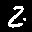

In [ ]:
Image(filename = "data/test_data/id_10_label_5.png", width = 32, height = 32)

In [ ]:
directory = "./data/train_data/"
images = os.listdir(directory)

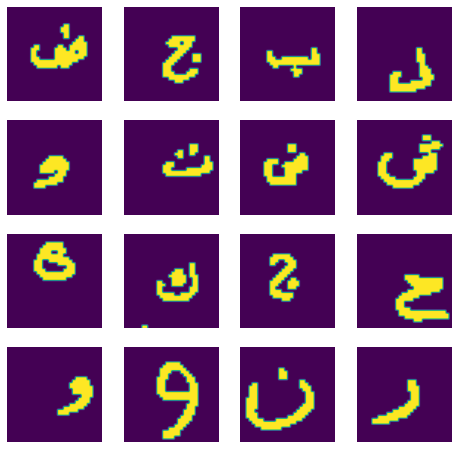

In [ ]:
ncols = 4
nrows = 4

fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

for i, img_path in enumerate(images[0:ncols*nrows]):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Disable axes display

    img = mpimg.imread(directory+img_path)
    plt.imshow(img)



In [ ]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [ ]:
batch_size = 32
img_height = 32
img_width = 32

def get_dataset(dataset_dir):
    
    def process_filename(file_path):
        label = tf.strings.regex_replace(input=file_path,pattern=r".+_label_(\d+)\.png", rewrite=r"\1")
        label = tf.strings.to_number(label, tf.int32)-1
        #label = tf.one_hot(label, depth=29)
        return label

    def process_img(file_path):

        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, size=(32, 32))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255.0
        return img
    
    data_dir = pathlib.Path(dataset_dir)
    file_list = [str(path.absolute()) for path in Path(data_dir).glob("*.png")]
    files_ds = tf.data.Dataset.from_tensor_slices((file_list))
    files_ds = files_ds.map(lambda x: (process_img(x), process_filename(x)))
    return files_ds

In [ ]:
import shutil, sys

In [ ]:
from keras.models import Sequential # to construct in CNN
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D # Operations on CNN
from keras.optimizers import RMSprop # RMSProp optimizer
from keras.preprocessing.image import ImageDataGenerator # Image generator class
from keras.callbacks import ReduceLROnPlateau # Reduce learning rate callback function

In [78]:
mkdir data/mnist_arabic

In [79]:
mkdir data/mnist_arabic/test

In [80]:
mkdir data/mnist_arabic/train

In [81]:
for i in range(1,29):
  os.mkdir("data/mnist_arabic/test/{}".format(i))
  os.mkdir("data/mnist_arabic/train/{}".format(i))

In [82]:
directory_train = "./data/train_data/"
images_train = os.listdir(directory_train)
directory_test = "./data/test_data/"
images_test = os.listdir(directory_test)

In [84]:
for image in images_train:
  if image.endswith('.png'):
    label =int(tf.strings.regex_replace(input=image,pattern=r".+_label_(\d+)\.png",rewrite =r"\1").numpy())
    original = directory_train+image
    target =("./data/mnist_arabic/train/{}/".format(label))+image
    shutil.copy2(original,target)

In [86]:
for image in images_test:
  if image.endswith('.png'):
    label =int(tf.strings.regex_replace(input=image,pattern=r".+_label_(\d+)\.png",rewrite =r"\1").numpy())
    original = directory_test+image
    target =("./data/mnist_arabic/test/{}/".format(label))+image
    shutil.copy2(original,target)

In [87]:
train_dataset_path1 = "data/mnist_arabic/train"
test_dataset_path1 = "data/mnist_arabic/test"

In [88]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [89]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [90]:
train_generator = train_datagen.flow_from_directory(
        train_dataset_path1,
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        test_dataset_path1,
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')

Found 13440 images belonging to 28 classes.
Found 3360 images belonging to 28 classes.


In [91]:
# Structure
model = tf.keras.models.Sequential([
    # CNN1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(28)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dropout (Dropout)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               7373312   
_________________________________________________________________
dense_1 (Dense)              (None, 28)                14364     
Total params: 7,389,468
Trainable params: 7,389,468
Non-trainable params: 0
______________________________________________

In [92]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

In [94]:
history = model.fit(train_generator,steps_per_epoch= 100,epochs=50,verbose=1,validation_data = validation_generator)

Epoch 1/50
100/100 [==============================] - 16s 155ms/step - loss: 8.8522 - accuracy: 0.0506 - val_loss: 8.9131 - val_accuracy: 0.0399
Epoch 2/50
100/100 [==============================] - 16s 156ms/step - loss: 9.7781 - accuracy: 0.0416 - val_loss: 9.4790 - val_accuracy: 0.0390
Epoch 3/50
100/100 [==============================] - 16s 155ms/step - loss: 9.7666 - accuracy: 0.0397 - val_loss: 9.4790 - val_accuracy: 0.0390
Epoch 4/50
100/100 [==============================] - 15s 155ms/step - loss: 9.4912 - accuracy: 0.0394 - val_loss: 9.2314 - val_accuracy: 0.0586
Epoch 5/50
100/100 [==============================] - 15s 154ms/step - loss: 9.0304 - accuracy: 0.0659 - val_loss: 9.2104 - val_accuracy: 0.0664
Epoch 6/50
100/100 [==============================] - 16s 155ms/step - loss: 7.7505 - accuracy: 0.0597 - val_loss: 8.0015 - val_accuracy: 0.0738
Epoch 7/50
100/100 [==============================] - 16s 156ms/step - loss: 8.0943 - accuracy: 0.0637 - val_loss: 8.0015 - val_ac

In [95]:
model.evaluate(validation_generator)

105/105 [==============================] - 3s 26ms/step - loss: nan - accuracy: 0.0357


[nan, 0.0357142873108387]